## Part 3: Apply Q-learning to an alternative environment

### 3.1. The Lunar Lander Environment

One of the standout features of Q-Learning is its model-free nature, which allows it to learn effective policies through interaction with the environment. This makes it highly adaptable and easily generalizable to different or more complex environments, unlike model-based methods such as Backward Induction. In this part, we will apply Q-Learning to a different environment, namely the [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment from OpenAI Gym. Here is a short discription of the this rocket trajectory optimization problem: 

* It has a 8-dimensional state vector, representing:
    * the x, y coordinates (continuous, floats)
    * the x, y velocities (continuous, floats)
    * the angle (continuous, float)
    * angular velocities (continuous, float)
    * ground contact of left and right legs (discrete, boolean)
* The 4 possible actions are discrete:
    * do nothing (integer 0)
    * fire left orientation engine (integer 1)
    * fire main engine (integer 2)
    * fire right orientation engine (integer 3)
* Rewards are designed to guide the rocket to land safely but quickly:
    * +100 for landing
    * -100 for crashing
    * -0.3 for using the main engine
    * -0.03 for using the orientation engines
    * -0.01 for each timestep
    * and a few more (see the [documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/) for details)
* From the documentation, "An episode is considered a solution if it scores at least 200 points." This will be the goal we aim for in this part.
    

In [19]:
'''
Initializes the Lunar Lander Environment
'''

import gymnasium as gym

lunarlander_env = gym.make(
    'LunarLander-v2',
    gravity=-10.0,
    enable_wind=True,
    wind_power=5.0,
    turbulence_power=1.5
)


### 3.2. Deep Q-Learning Agent

When the state space becomes large or even continuous, using a Q-Table to approximate the Q-Function becomes impractical due to the prevalence of under-visited states. In contrast, neural networks can handle continuous inputs and effectively approximate Q-values for rarely visited states, making Deep Q-Learning well-suited for such complex environments.

#### What's new compared to Q-Learning:

* Deep Q-Learning uses a neural network to approximate the optimal Q-value fucntion $Q^*(x, u)$, instead of using a lookup table: 

    * $Q(x, u; w) \approx Q*(x, u)$, where w are the weights / parameters of the neural network.

* Also the replay buffer, a memory data structure that stores past experiences $(x, u, r, x')$ is added. This allows the network to sample mini-batches of transitions for training, making the learning more stable and efficient.

#### Training the agent:

* Initialize the Q-network with random weights or pre-trained weights.
* For each episode
    * Reset the environment and get the initial state $x$.
    * For each timestep
        * Select an action $u$ using the $\epsilon$-greedy policy, either randomly or by a forward pass through the Q-network.
        * Interact with the environment and get the reward $r_t$ and the next state $x'$.
        * Store the experience $(x, u, r, x')$ in the replay buffer.
        * Sample a mini-batch of experiences from the replay buffer.
        * For each experience $(x_i, u_i, r_i, x_i')$ in the mini-batch
            * Compute the target Q-value $\text{Target}$ using the Bellman equation:
                * $\text{Target} = r_i + \gamma \max_{u'} Q(x_i', u'; w)$
            * Calculate the loss by the square error between the target and the current Q-value: 
                * $\text{Loss} = (\text{Target} - Q(x_i, u_i; w))^2$
        * Update the Q-network by backpropagation on the loss from all the experiences in the mini-batch.




In [20]:
'''
Prepare the train function
'''
import numpy as np

import pickle

from agent_DQL import AgentDQL

# Numpy suppress warnings
import warnings
warnings.filterwarnings('ignore')

def train_agent(env, agent, n_games=500, save_path='trained_models/dqn_model.pth'):


    train_scores_history = []
    avg_scores_history = []

    for i in range(1, n_games + 1):
        score = 0
        done = False
        state, info = env.reset()
        step_cnt = 0
        while not done:
            action = agent.choose_action(state)
            state_, reward, done, truncated, info = env.step(action)
            score += reward
            agent.store_transition(state, action, reward, state_, done)
            agent.learn()
            step_cnt += 1
            state = state_

        if len(train_scores_history) >= 100:
            avg_score = np.mean(train_scores_history[-100:])
        else:
            avg_score = np.mean(train_scores_history)

        train_scores_history.append(score)
        avg_scores_history.append(avg_score)
        if i % 50 == 0:
            print('episode: ', i,'episode score %.2f' % score,
                    'average score %.2f' % avg_score,
                    'epsilon %.2f' % agent.epsilon)
        
    agent.save_model(save_path)


    return train_scores_history

In [21]:
agent_dql = AgentDQL(gamma=0.99, epsilon=1.0, lr=0.001,
                        input_dims=lunarlander_env.observation_space.shape[0],
                        batch_size=64,
                        n_actions=lunarlander_env.action_space.n,
                        max_mem_size=1000000,
                        eps_min=0.01,
                        eps_dec=5e-4)

In [ ]:
scores_dql_500 = train_agent(lunarlander_env, agent_dql, n_games=500, 
                             save_path='trained_models/dqn_model_500.pth')

# Save scores to a file
with open('trained_models/dqn_scores_500.pkl', 'wb') as f:
    pickle.dump(scores_dql_500, f)

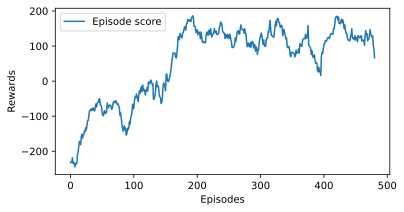

In [22]:
# Plot the scores
from tools import plot_learning_curve

# Load scores from a file
try:
    with open('trained_models/dqn_scores_500.pkl', 'rb') as f:
        scores_dql_500 = pickle.load(f)
    plot_learning_curve(scores_dql_500, 20, 'Lunar Lander DQL', 'Episodes', 'Rewards')
except:
    print("Train the agent for 500 episodes first!")



* As we can see, the rewards goes up at around 200 episodes, and fluctuates around 100 to 200.

Let's the training for 1000 episodes

In [ ]:
agent_dql = AgentDQL(gamma=0.99, epsilon=1.0, lr=0.001,
                        input_dims=lunarlander_env.observation_space.shape[0],
                        batch_size=64,
                        n_actions=lunarlander_env.action_space.n,
                        max_mem_size=1000000,
                        eps_min=0.01,
                        eps_dec=5e-4)


# Train for another 500 episodes
scores_dql_1000 = train_agent(lunarlander_env, agent_dql, n_games=1000, save_path='trained_models/dqn_model_1000.pth')

# Save scores to a file
with open('trained_models/dqn_scores_1000.pkl', 'wb') as f:
    pickle.dump(scores_dql_1000, f)

In [16]:
# Save scores to a file
with open('trained_models/dqn_scores_1000.pkl', 'wb') as f:
    pickle.dump(scores_dql_1000, f)

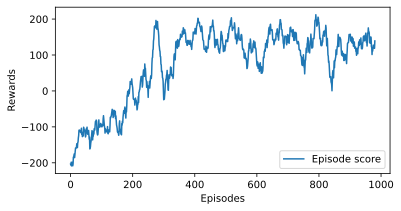

In [17]:
'''
Plot the new scores
'''
# Load scores from a file
try:
    with open('trained_models/dqn_scores_1000.pkl', 'rb') as f:
        scores_dql_1000 = pickle.load(f)
    plot_learning_curve(scores_dql_1000, 20, 'Lunar Lander DQL', 'Episodes', 'Rewards')
except:
    print("Train the agent first!")

* As we can see, the score is still fluctuating between 0 to 200. 
* While it could pass the 200 mark occasionally, it could drop as low as to 0.
* The overall performance does not get any better if not worse compare to the previous 500 episode.

### 3.3. Stablise the Learning: DQL with Target Network

* Adding a target network to a Deep Q-Learning (DQN) agent involves creating a second neural network whose architecture is identical to the main Q-network. This target network is used to generate the target Q-values for training the main Q-network.

* The target network is updated periodically with the weights from the main Q-network. This helps to stablise the learning process and improve the performance of the agent.

Let's see how the agent performs with a target network.

In [7]:
'''
Train with a target network
'''
from agent_targetNN import AgentTargetNN

env = lunarlander_env

agent_target = AgentTargetNN(
    gamma=0.99, epsilon=1.0, lr=0.0005,
    input_dims=env.observation_space.shape[0],
    batch_size=64,
    n_actions=env.action_space.n,
    max_mem_size=1000000,
    eps_min=0.01,
    eps_dec=0.001,
    tar_update=100
)

In [8]:
# Train for 1000 episodes
scores_target_1000 = train_agent(env, agent_target, n_games=1000, 
                                 save_path='target_model_1000.pth')
# Save scores to a file
with open('trained_models/target_scores_1000.pkl', 'wb') as f:
    pickle.dump(scores_target_1000, f)

episode:  50 episode score -168.06 average score -181.46 epsilon 0.01
episode:  100 episode score -5.94 average score -217.49 epsilon 0.01
episode:  150 episode score 44.28 average score -171.94 epsilon 0.01
episode:  200 episode score 242.02 average score 16.55 epsilon 0.01
episode:  250 episode score 114.85 average score 140.79 epsilon 0.01
episode:  300 episode score 201.28 average score 138.94 epsilon 0.01
episode:  350 episode score -2.17 average score 156.09 epsilon 0.01
episode:  400 episode score 300.78 average score 185.80 epsilon 0.01
episode:  450 episode score -185.74 average score 163.05 epsilon 0.01
episode:  500 episode score 225.39 average score 158.30 epsilon 0.01
episode:  550 episode score 248.55 average score 192.47 epsilon 0.01
episode:  600 episode score 253.67 average score 218.09 epsilon 0.01
episode:  650 episode score 257.50 average score 232.82 epsilon 0.01
episode:  700 episode score 254.44 average score 230.17 epsilon 0.01
episode:  750 episode score 266.33

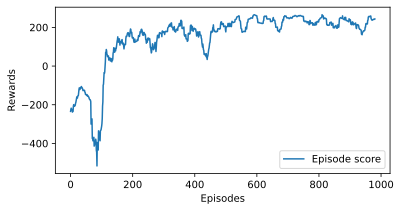

In [18]:
# Plot the scores
from tools import plot_learning_curve

# Load scores from a file
# try:
with open('trained_models/target_scores_1000.pkl', 'rb') as f:
    scores_target_1000 = pickle.load(f)
plot_learning_curve(scores_target_1000, 20, 'Lunar Lander DQL', 'Episodes', 'Rewards')
# except:
#     print("Train the agent first!")

* In the graph, the reward stabilizes after 500 games, consistently surpassing a score of 200, indicating that the policy can be considered optimal.
* Compared to Deep Q-Learning without a target network, the performance and stability improvements observed here are quite significant.


### 3.4. Conclusion

This part demostrate the power of Deep Q-Learning in one of it's most successfull field--playing games. With various modification to Q-Learning, it is able to handle a environment with very large state space. Also, learning a near-optimal policy within only 1000 games with no prior knowledge and assumptions about the environment is remarkable. If this game stop providing any graphical information, learning within a few hundred games could be a big challenge for human.



Backward induction, Q-Learning, and Deep Q-Learning are distinct methods for solving decision-making problems, each with its own set of advantages and limitations.

* Backward induction (BI) is a classic technique often used in deterministic and fully observable environments. However, the brute-force search that covers the entire state space makes it computationally infeasible for large state spaces. While fast approximations such as deterministic backward induction can enhance performance, they are not universally applicable across different environments and often struggle to scale effectively in the face of large state spaces as well.

* Q-Learning is a reinforcement learning algorithm that excels in an environment with unknown model. Also the ability to focus on important state makes it more scalable than BI, and it can handle medium-sized state-action spaces relatively well. However, it could struggles against high-dimensional or continuous spaces. 

* Deep Q-Learning extends Q-Learning by using neural networks as function approximators, enabling it to tackle problems with complex, high-dimensional state spaces effectively. The incorporation of a replay buffer and a target network also makes the learning more stable and efficient. However, the large parameter space of neural networks makes it need powerful computational resources to train and may take a long time to converge. Additionally, incorporating extra techniques may introduce more hyperparameters, making the tuning process exponentially more challenging.

